<a href="https://colab.research.google.com/github/tsenga2/keio-quant-macro/blob/main/gourio.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

log(Y) 1.1301 log(K) 2.0127 log(TFP) 0.1238
log(Y) 1.2121 log(K) 1.9925 log(TFP) 0.1627


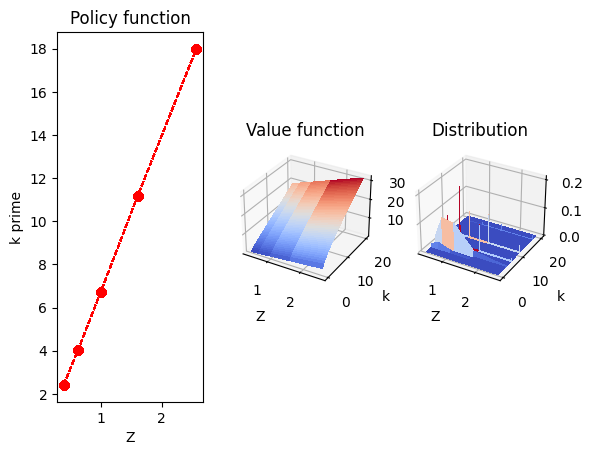

In [49]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import interpolate
from mpl_toolkits.mplot3d import Axes3D

# Function: gridlookup
def gridlookup(n, grid, val):
    # Find the index of the closest value in the grid
    idx = (np.abs(grid - val)).argmin()

    # If the value is greater than the grid value, the weight is the difference
    if val > grid[idx]:
    #if val > grid[idx]:
        weight = val - grid[idx]
    # Otherwise, the weight is 1 minus the difference
    else:
        weight = 1 - (grid[idx] - val)

    return idx, weight


# Parameters
alpha = 0.5
delta = 0.167
r = 0.04
rho = 0.55
mu = 0
sigma = 0.35

# Setup a grid for capital
nk = 200
kmin = 0.001
kmax = 20
kgrid = np.linspace(kmin, kmax, nk)
# Setup a grid for productivity
nz = 5

# Discrete-state approximation to AR1
# log(Z') = rho*log(Z) + (1-rho)*mu + sigma*epsilon
z = [-0.942927835640568, -0.471463917820284, 0, 0.471463917820284, 0.942927835640568]
Z = np.exp(z)
Pie = np.array([[0.295006943581673, 0.495512193838656, 0.193910257281772, 0.015339978264313, 0.000230627033585],
              [0.100327482548650, 0.426521772368601, 0.394527290061208, 0.075746025821068, 0.002877429200473],
              [0.021662684832732, 0.228645617148758, 0.499383396037020, 0.228645617148758, 0.021662684832732],
              [0.002877429200473, 0.075746025821068, 0.394527290061208, 0.426521772368602, 0.100327482548650],
              [0.000230627033585, 0.015339978264313, 0.193910257281772, 0.495512193838656, 0.295006943581673]])
# Decision (VFI)
v = np.zeros((nz, nk))
Tv = np.zeros((nz, nk))
g_vfi = np.zeros((nz, nk))

tol = 1e-6

for it in range(1000):
    ev = Pie @ v

    for i in range(nz):
        Zval = Z[i]

        for j in range(nk):
            kval = kgrid[j]

            RHS = np.empty(nk)
            for jj in range(nk):
                kfval = kgrid[jj]
                RHS[jj] = Zval * kval**alpha - kfval + (1 - delta) * kval + (1 / (1 + r)) * ev[i, jj]

            Tv[i, j] = np.max(RHS)
            g_vfi[i, j] = kgrid[np.argmax(RHS)]

    error = np.max(np.abs(Tv - v))

    if np.linalg.norm(Tv - v, np.inf) < tol:
        break

    v = Tv

# Plot figures
fig = plt.figure('Gourio2008')

ax1 = fig.add_subplot(1, 3, 1)
ax1.plot(Z, g_vfi, '--or', linewidth=1)
ax1.set_xlabel('Z')
ax1.set_ylabel('k prime')
ax1.set_title('Policy function')

ax2 = fig.add_subplot(1, 3, 2, projection='3d')
X, Y = np.meshgrid(Z, kgrid)
ax2.plot_surface(X, Y, v.T, cmap=plt.cm.coolwarm, linewidth=0, antialiased=False)
ax2.set_xlabel('Z')
ax2.set_ylabel('k')
ax2.set_title('Value function')


# Distribution
mu = np.zeros((nz, nk))
mu[0, 0] = 1
munext = np.zeros((nz, nk))

for it in range(200):
    for i in range(nz):
        for j in range(nk):
            muval = mu[i, j]

            if muval > 0:
                kloc, kweight = gridlookup(nk, kgrid, g_vfi[i, j])
                for ii in range(nz):
                    munext[ii, kloc] += Pie[i, ii] * kweight* muval
                    munext[ii, kloc + 1] += Pie[i, ii] * (1 - kweight) * muval

    error = np.max(np.abs(munext - mu))

    if np.linalg.norm(munext - mu, np.inf) < tol:
        break

    mu = munext
    munext = np.zeros((nz, nk))

# Plot figures
ax3 = fig.add_subplot(1, 3, 3, projection='3d')
X, Y = np.meshgrid(Z, kgrid)
ax3.plot_surface(X, Y, munext.T, cmap=plt.cm.coolwarm, linewidth=0, antialiased=False)
ax3.set_xlabel('Z')
ax3.set_ylabel('k')
ax3.set_title('Distribution')


# Aggregation
yagg = 0
kagg = 0

for i in range(nz):
    for j in range(nk):
        muval = mu[i, j]
        yagg += muval * Z[i] * kgrid[j]**alpha
        kagg += muval * kgrid[j]

tfp = np.exp(np.log(yagg) - alpha * np.log(kagg))

print(f'log(Y) {np.log(yagg):.4f} log(K) {np.log(kagg):.4f} log(TFP) {np.log(tfp):.4f}')


# analytical solution feasible
mu = 0
logy = mu + 0.5*(sigma**2/(1-rho)) + alpha/(1-alpha)*(mu+0.5*sigma**2) - alpha/(1-alpha)*np.log((r+delta)/alpha) + 0.5*alpha**2*(rho/(1-alpha))**2*(sigma**2/(1-rho**2)) + (rho**2/(1-alpha))*(sigma**2/(1-rho**2))
logk = 1/(1-alpha)*(mu+0.5*sigma**2) - 1/(1-alpha)*np.log((r+delta)/alpha) + 0.5*(rho/(1-alpha))**2*(sigma**2/(1-rho**2))
logtfp = mu + 0.5*(sigma**2/(1-rho)) + (rho**2*alpha)/(1-alpha)*((sigma**2)/(1-rho**2))*0.5

print(f'log(Y) {logy:.4f} log(K) {logk:.4f} log(TFP) {logtfp:.4f}')

